__please create and use an environment from the siemens-poc.yml by Cynthia__

_note: to get the full experience, please install jupyter nbextensions using ```pip install jupyter_contrib_nbextensions && jupyter contrib  nbextension install```, restart jupyter and navigate to the new Nbextensions tab and check ```Table of Contents (2)``` , ```Collapsible headings```, ```Codefolding``` and ```Split Cells Notebook```._

__set width__

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Teradata Vantage Demo - Random Forest

__exploration on the local machine and on the cluster can be done within the same notebook!!!__

_please note that all imports drom tdml will be renamed with ```td_``` as prefix to highlight them_

- An introduction to the tdml package can be found here: https://docs.teradata.com/reader/eteIDCTX4O4IMvazRMypxQ/we8tsrLOuIe~zO~~h9n7Ug
- the full documentation of the _still growing_ functionality of tdml for Python can be found here: https://docs.teradata.com/reader/GsM0pYRZl5Plqjdf9ixmdA/MzdO1q_t80M47qY5lyImOA

----

The task is to predict the level of NO2 given the time of measurement, the air humidity, temperature and pressure

There is one record for every 30 minutes for the entire of 2017 and 2018 

### imports

In [9]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV,KFold
from sklearn.ensemble import RandomForestRegressor

from teradataml.analytics import RandomSample as td_RandomSample

from teradataml.context.context import create_context as td_create_context

from teradataml.dataframe.dataframe import DataFrame as td_DataFrame

import datetime


from teradataml.analytics import DecisionForest as td_DecisionForest
from teradataml.analytics import DecisionForestPredict as td_DecisionForestPredict 



from teradataml.dataframe.dataframe import copy_to_sql as td_copy_to_sql

### connect with the database

In [4]:
server = "tddb-env-d-268.vantage.demo.intellicloud.teradata.com"
user = "Vantage"
password = "analytics"
eng = td_create_context(host = server, username = user, password = password)
conn = eng.connect()

# Data Exploration and Visualisation using open-source packages on local machine

## get subset of the data from database to local machine

### get pointer for teradata dataframe

We assume that the entire data is already in the database with the name ```siemens_NO2_prediction```.

In [4]:
name_of_table = 'siemens_NO2_prediction'

In [5]:
NO2_tddf = td_DataFrame.from_table(name_of_table)

note that NO2_tddf is not downloaded/saved locally!

### download random sample as pandas Dataframe

from the 35032 samples we take a random sub-sample of 10000 for exploration. Note that in a real case the real database could contain billions of rows.

In [39]:
NO2_pddf = td_RandomSample(data=NO2_tddf, num_sample=10000).result.to_pandas()


In [41]:
NO2_pddf.head()

,datetime,no2,luftdruck,luftfeuchtigkeit,temperatur
set_id,,,,,
0,2017-05-24 12:00:00+00:00,109.8,1024.0,57.0,19.8
0,2018-11-21 16:00:00+00:00,53.2,1018.0,80.0,3.4
0,2017-08-16 02:00:00+00:00,40.3,1021.0,97.0,16.7
0,2017-07-17 21:30:00+00:00,17.2,1022.0,82.0,19.5
0,2017-08-19 13:00:00+00:00,47.3,1020.0,43.0,20.9


## Feature Pre-Processing

### temporal features

In [12]:
def getTemporalFeatures(df):
    df['datetime']=pd.DatetimeIndex(df.datetime).tz_localize('UTC')
    df['datetime'] = pd.DatetimeIndex(df.datetime).tz_convert('Europe/Berlin')
    df['year'] = df.datetime.dt.year
    df['hour'] = df.datetime.dt.hour
    df['dayofweek'] = df.datetime.dt.dayofweek.replace(
            {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday",
             5: "Saturday", 6: "Sunday"})
    df['month'] = df.datetime.dt.date.apply(lambda x: x.month)
    return df

In [13]:
NO2_pddf = getTemporalFeatures(NO2_pddf)

### one-hot-encode hour,week, year

In [14]:
NO2_pddf = pd.concat(
 [NO2_pddf,  
  pd.get_dummies(NO2_pddf.hour, prefix="hour_")],
    axis=1)

In [15]:
NO2_pddf = pd.concat(
 [NO2_pddf,  
  pd.get_dummies(NO2_pddf.dayofweek, prefix="weekday_")],
    axis=1)

In [16]:
NO2_pddf = pd.concat(
 [NO2_pddf,  
  pd.get_dummies(NO2_pddf.month, prefix="month_")],
    axis=1)

## Inspection and missing values

In [22]:
NO2_pddf.columns

Index(['datetime', 'no2', 'luftdruck', ' luftfeuchtigkeit', ' temperatur',
       'year', 'hour', 'dayofweek', 'month', 'hour__0', 'hour__1', 'hour__2',
       'hour__3', 'hour__4', 'hour__5', 'hour__6', 'hour__7', 'hour__8',
       'hour__9', 'hour__10', 'hour__11', 'hour__12', 'hour__13', 'hour__14',
       'hour__15', 'hour__16', 'hour__17', 'hour__18', 'hour__19', 'hour__20',
       'hour__21', 'hour__22', 'hour__23', 'weekday__Friday',
       'weekday__Monday', 'weekday__Saturday', 'weekday__Sunday',
       'weekday__Thursday', 'weekday__Tuesday', 'weekday__Wednesday',
       'month__1', 'month__2', 'month__3', 'month__4', 'month__5', 'month__6',
       'month__7', 'month__8', 'month__9', 'month__10', 'month__11',
       'month__12'],
      dtype='object')

__there are missing values --> need to be dropped__

In [18]:
NO2_pddf.isna().sum()

datetime               0
no2                   35
luftdruck             22
 luftfeuchtigkeit     24
 temperatur           24
year                   0
hour                   0
dayofweek              0
month                  0
hour__0                0
hour__1                0
hour__2                0
hour__3                0
hour__4                0
hour__5                0
hour__6                0
hour__7                0
hour__8                0
hour__9                0
hour__10               0
hour__11               0
hour__12               0
hour__13               0
hour__14               0
hour__15               0
hour__16               0
hour__17               0
hour__18               0
hour__19               0
hour__20               0
hour__21               0
hour__22               0
hour__23               0
weekday__Friday        0
weekday__Monday        0
weekday__Saturday      0
weekday__Sunday        0
weekday__Thursday      0
weekday__Tuesday       0
weekday__Wednesday     0


In [19]:
NO2_pddf = NO2_pddf.dropna()

## Visualisation

In [21]:
x=NO2_pddf[['no2', 'luftdruck', 'luftfeuchtigkeit', 'temperatur']].hist()

KeyError: "['luftfeuchtigkeit' 'temperatur'] not in index"

In [ ]:
x=pd.plotting.scatter_matrix(
    NO2_pddf[['no2', 'luftdruck', 'luftfeuchtigkeit', 'temperatur']],
    alpha=0.01
)



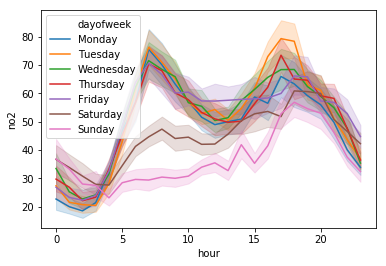

In [34]:
sns.lineplot(
    data=NO2_pddf, x='hour', y='no2',
    hue='dayofweek', legend='full',
    hue_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                   "Saturday", "Sunday"]
)

In [89]:
NO2_pddf.head()

,datetime,no2,luftdruck,luftfeuchtigkeit,temperatur
set_id,,,,,
0,2017-01-11 12:30:00+00:00,91.4,1007.0,96.0,2.5
0,2018-11-03 14:00:00+00:00,42.0,1026.0,50.0,14.0
0,2018-07-28 21:30:00+00:00,47.8,1014.0,71.0,20.6
0,2017-11-11 09:00:00+00:00,56.5,1013.0,93.0,5.5
0,2018-08-17 19:00:00+00:00,28.9,1019.0,70.0,21.0


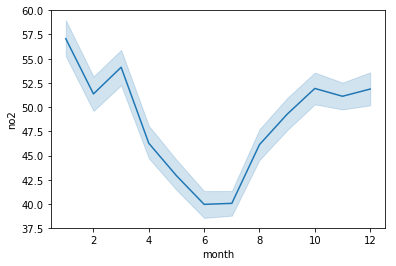

In [99]:
sns.lineplot(
    data=NO2_pddf, x='month', y='no2',
    #hue='dayofweek', legend='full',
   # hue_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
    #               "Saturday", "Sunday"]
)

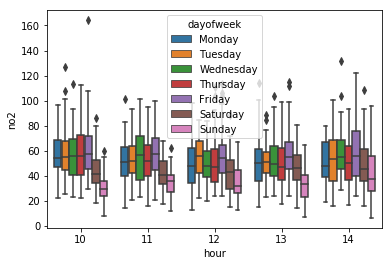

In [35]:
sns.boxplot(
        data=NO2_pddf[(NO2_pddf.hour <15) & (NO2_pddf.hour >9)],
        x='hour',
        y='no2',
        hue='dayofweek',
        hue_order=["Monday","Tuesday","Wednesday","Thursday","Friday",
             "Saturday","Sunday"]
    )

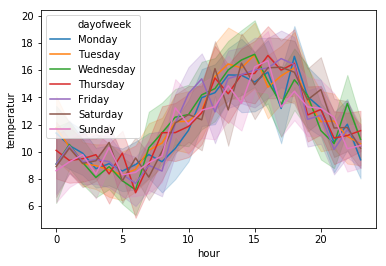

In [36]:
sns.lineplot(
    data=NO2_pddf, x='hour', y='temperatur', 
    hue='dayofweek', legend='full',hue_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                   "Saturday", "Sunday"])

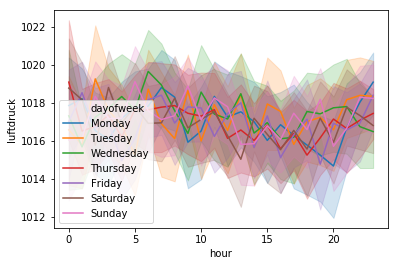

In [37]:
sns.lineplot(
    data=NO2_pddf, x='hour', y='luftdruck', 
    hue='dayofweek', legend='full',hue_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                   "Saturday", "Sunday"])

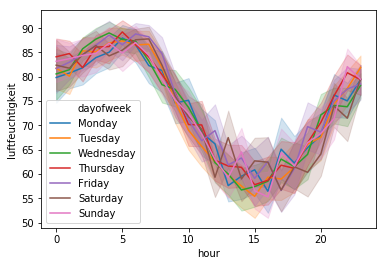

In [38]:
sns.lineplot(
    data=NO2_pddf, x='hour', y='luftfeuchtigkeit', 
    hue='dayofweek', legend='full',hue_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                   "Saturday", "Sunday"])

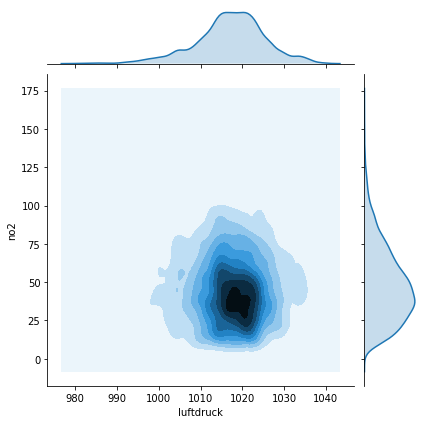

In [40]:
sns.jointplot(x="luftdruck",y="no2", data = NO2_pddf,kind="kde")

## Hyper-parameter tuning for Random Forest

In [44]:
X= NO2_pddf[['luftdruck', 'luftfeuchtigkeit', 'temperatur','year']+list(NO2_pddf.columns[9:])]

In [45]:
y = NO2_pddf[["no2"]]

In [46]:
hyperparams_rf = {
    "n_estimators":[150,300], #[50,100,150],
    "max_depth":[35,40,45,50], #[10,20,20],
    'min_samples_leaf': [1], #[1, 2, 4],
    'min_samples_split': [2],#[2, 5, 10],
    "max_features":[25,30,35] #[10,20,20] 
}

In [47]:
randomseed=23

In [48]:
gridsearch = GridSearchCV(
    RandomForestRegressor(random_state=randomseed,n_jobs=1),
    param_grid=hyperparams_rf,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    cv=KFold(n_splits=3,shuffle=True,random_state=randomseed),
    verbose=3

)

In [49]:
gridsearch = gridsearch.fit(X,y.no2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=35, max_features=25, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=35, max_features=25, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=35, max_features=25, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=35, max_features=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV] max_depth=35, max_features=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV] max_depth=35, max_features=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV] max_depth=35, max_features=30, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=35, max_features=30, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=35, max_features=30, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=35, max_features=30, min_samples_leaf=1, min_samples_split=2, n_estim

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.2s


[CV]  max_depth=35, max_features=35, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=-12.001368570049763, total=   7.5s
[CV] max_depth=40, max_features=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV]  max_depth=35, max_features=35, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=-12.01609630271147, total=   7.6s
[CV]  max_depth=35, max_features=35, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=-11.90886011045759, total=   7.6s
[CV] max_depth=40, max_features=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV]  max_depth=35, max_features=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=-11.95511388510156, total=  12.3s
[CV] max_depth=40, max_features=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV] max_depth=40, max_features=30, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  max_depth=35, max_features=30, min_samples_leaf=1, min_samples_split=

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.6min finished


In [50]:
gridsearch.best_params_

{'max_depth': 50,
 'max_features': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [51]:
-(np.abs(y.no2-y.no2.mean())).mean()

-19.42178169919687

In [52]:
gridsearch.best_score_

-11.903050066177466

In [53]:
ft = X.columns

In [54]:
fi = gridsearch.best_estimator_.feature_importances_

In [55]:
dfidf= pd.DataFrame({"feat":ft,"importance":fi}
                   ).set_index("feat").sort_values("importance",ascending=False)

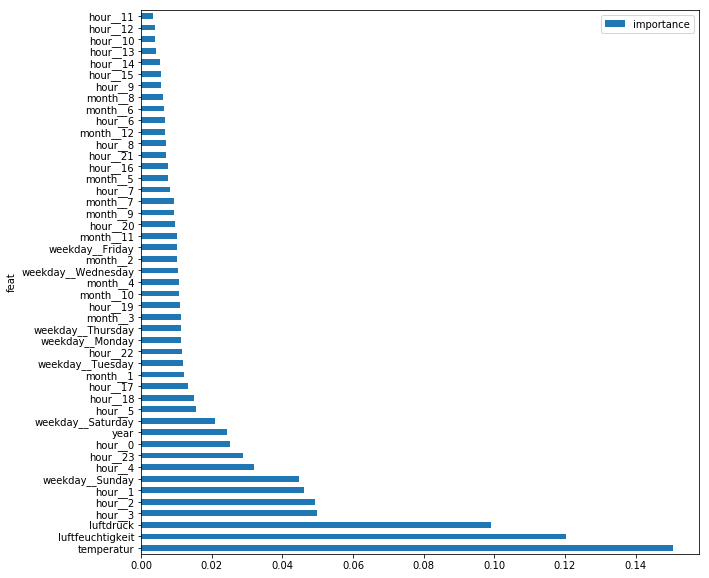

In [57]:
dfidf.plot.barh(figsize=(10,10))

In [152]:
resultsGS = pd.DataFrame(gridsearch.cv_results_)[
    ['mean_test_score','mean_train_score', 'param_max_depth', 
     'param_max_features','param_min_samples_leaf', 
     'param_min_samples_split','param_n_estimators',]]

In [ ]:
resultsGS

In [153]:
resultsGS.shape

(24, 7)

In [154]:
def plotParamresult(stringOfHP="param_max_depth"):
    plt.figure()
    sns.lineplot(
        data=resultsGS, x=stringOfHP, y='mean_test_score', label="test"
    )
    sns.lineplot(
        data=resultsGS, x=stringOfHP, y='mean_train_score',label="train"
    )

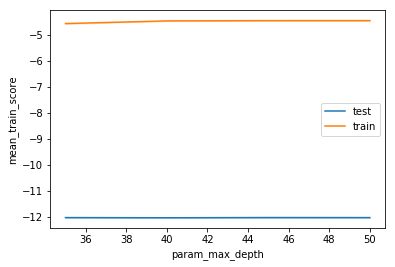

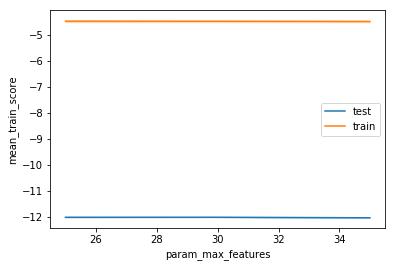

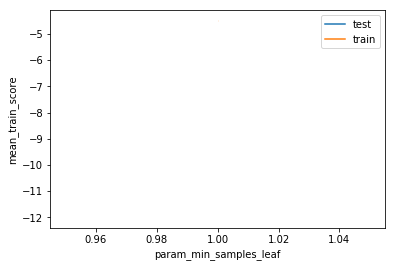

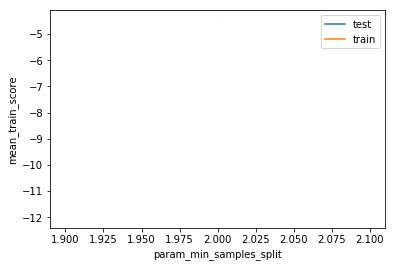

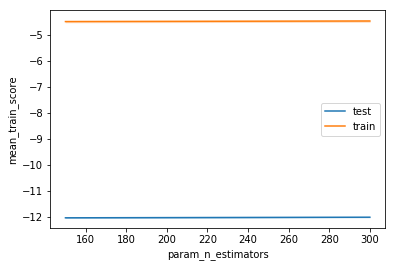

In [155]:
plotParamresult("param_max_depth")
plotParamresult("param_max_features")
plotParamresult("param_min_samples_leaf")
plotParamresult("param_min_samples_split")
plotParamresult("param_n_estimators")

## Hyper-parameter tuning for Random Forest non one hot encoded features

In [42]:
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.ensemble import RandomForestRegressor

In [61]:
NO2_pddf['dayofweek'] = NO2_pddf.datetime.dt.dayofweek

In [63]:
NO2_pddf.columns

Index(['datetime', 'no2', 'luftdruck', 'luftfeuchtigkeit', 'temperatur',
       'year', 'hour', 'dayofweek', 'month', 'hour__0', 'hour__1', 'hour__2',
       'hour__3', 'hour__4', 'hour__5', 'hour__6', 'hour__7', 'hour__8',
       'hour__9', 'hour__10', 'hour__11', 'hour__12', 'hour__13', 'hour__14',
       'hour__15', 'hour__16', 'hour__17', 'hour__18', 'hour__19', 'hour__20',
       'hour__21', 'hour__22', 'hour__23', 'weekday__Friday',
       'weekday__Monday', 'weekday__Saturday', 'weekday__Sunday',
       'weekday__Thursday', 'weekday__Tuesday', 'weekday__Wednesday',
       'month__1', 'month__2', 'month__3', 'month__4', 'month__5', 'month__6',
       'month__7', 'month__8', 'month__9', 'month__10', 'month__11',
       'month__12'],
      dtype='object')

In [62]:
NO2_pddf.head()

,datetime,no2,luftdruck,luftfeuchtigkeit,temperatur,year,hour,dayofweek,month,hour__0,...,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
12171,2017-09-11 15:30:00+02:00,46.8,1002.0,46.0,19.5,2017,15,0,9,0,...,0,0,0,0,0,0,1,0,0,0
6122,2017-05-08 15:00:00+02:00,45.0,1019.0,63.0,10.4,2017,15,0,5,0,...,0,0,1,0,0,0,0,0,0,0
22964,2018-04-24 14:00:00+02:00,47.0,1017.0,38.0,20.6,2018,14,1,4,0,...,0,1,0,0,0,0,0,0,0,0
1943,2017-02-10 12:30:00+01:00,53.3,1021.0,76.0,0.8,2017,12,4,2,0,...,0,0,0,0,0,0,0,0,0,0
19449,2018-02-10 07:30:00+01:00,60.8,1016.0,92.0,0.1,2018,7,5,2,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
X= NO2_pddf[['luftdruck', 'luftfeuchtigkeit', 'temperatur','year','month', 'dayofweek','hour', ]]
            

In [65]:
y = NO2_pddf[["no2"]]

In [66]:
hyperparams_rf = {
    "n_estimators":[150,300], #[50,100,150],
    "max_depth":[35,40,45,50], #[10,20,20],
    'min_samples_leaf': [1], #[1, 2, 4],
    'min_samples_split': [2],#[2, 5, 10],
    "max_features":[7] #[10,20,20] 
}

In [67]:
randomseed=23

In [68]:
gridsearch = GridSearchCV(
    RandomForestRegressor(random_state=randomseed,n_jobs=1),
    param_grid=hyperparams_rf,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    cv=KFold(n_splits=3,shuffle=True,random_state=randomseed),
    verbose=3

)

In [69]:
gridsearch = gridsearch.fit(X,y.no2)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=35, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=35, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=35, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=35, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV] max_depth=35, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV] max_depth=35, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV] max_depth=40, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=40, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=40, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV] max_depth=40, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:    7.8s remaining:   10.9s


[CV]  max_depth=50, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=-11.274375096693282, total=   3.6s
[CV]  max_depth=50, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=-11.458080536761715, total=   3.6s
[CV]  max_depth=50, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=-11.363130482894013, total=   3.5s
[CV]  max_depth=45, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=-11.430743819100291, total=   7.4s
[CV]  max_depth=45, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=-11.265002431692418, total=   7.5s
[CV]  max_depth=45, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=-11.344114562354859, total=   7.5s


[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:   11.6s remaining:    3.1s


[CV]  max_depth=50, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=-11.430743819100291, total=   6.0s
[CV]  max_depth=50, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=-11.344114562354859, total=   6.0s
[CV]  max_depth=50, max_features=7, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=-11.265002431692418, total=   6.1s


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   14.2s finished


In [70]:
gridsearch.best_params_

{'max_depth': 40,
 'max_features': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [71]:
-(np.abs(y.no2-y.no2.mean())).mean()

-19.42178169919687

In [72]:
gridsearch.best_score_

-11.346612064952332

In [73]:
ft = X.columns

In [74]:
fi = gridsearch.best_estimator_.feature_importances_

In [75]:
dfidf= pd.DataFrame({"feat":ft,"importance":fi}
                   ).set_index("feat").sort_values("importance",ascending=False)

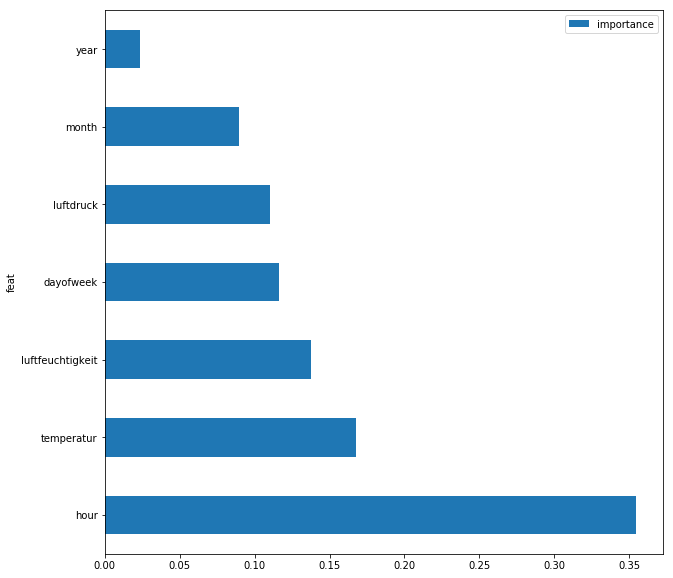

In [76]:
dfidf.plot.barh(figsize=(10,10))

In [152]:
resultsGS = pd.DataFrame(gridsearch.cv_results_)[
    ['mean_test_score','mean_train_score', 'param_max_depth', 
     'param_max_features','param_min_samples_leaf', 
     'param_min_samples_split','param_n_estimators',]]

In [ ]:
resultsGS

In [153]:
resultsGS.shape

(24, 7)

In [154]:
def plotParamresult(stringOfHP="param_max_depth"):
    plt.figure()
    sns.lineplot(
        data=resultsGS, x=stringOfHP, y='mean_test_score', label="test"
    )
    sns.lineplot(
        data=resultsGS, x=stringOfHP, y='mean_train_score',label="train"
    )

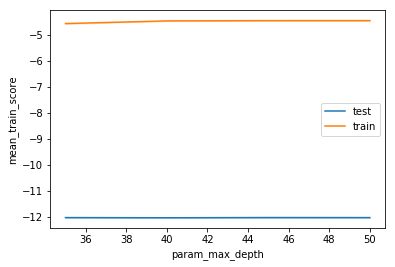

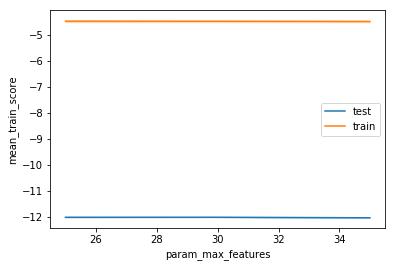

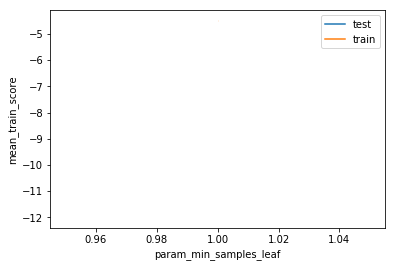

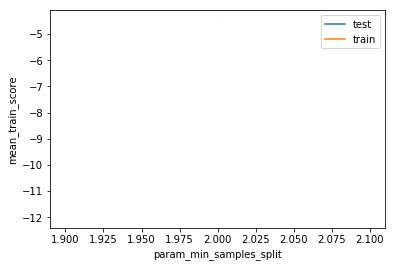

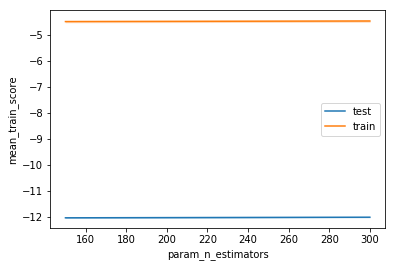

In [155]:
plotParamresult("param_max_depth")
plotParamresult("param_max_features")
plotParamresult("param_min_samples_leaf")
plotParamresult("param_min_samples_split")
plotParamresult("param_n_estimators")

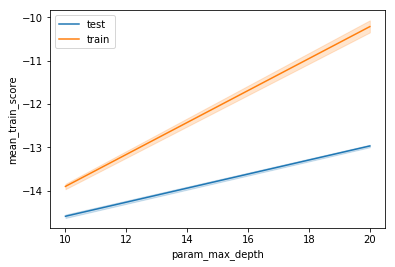

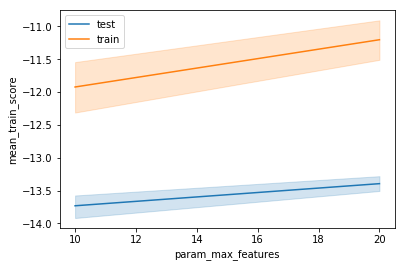

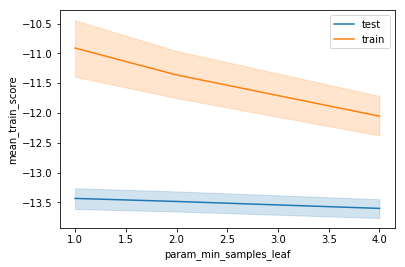

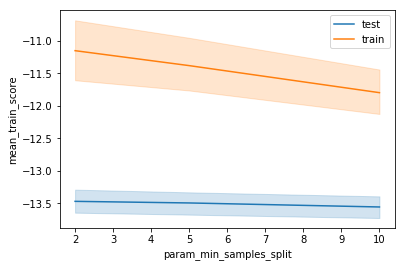

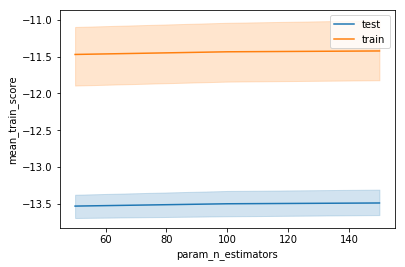

In [122]:
plotParamresult("param_max_depth")
plotParamresult("param_max_features")
plotParamresult("param_min_samples_leaf")
plotParamresult("param_min_samples_split")
plotParamresult("param_n_estimators")

# Translate Functions from Notebook into tdml

This chapter contains the translated classes from the Notebook, the standard python classes/functions got the prefix ```pd_```

__assume that we have already a connection established to vantage as desribed above__

In [6]:
DATA_PATH = "" # because it is not saved on the local system

In [7]:
name_of_table = 'siemens_NO2_prediction'

## Intervall

In [10]:
#no change, logic for slicing is in DataAccess.get_data()
class Interval(object):
    """Some date utility. Would be imported from some other module."""
    _format = "%d-%m-%Y-%H-%M-%S"

    def __init__(self, start: datetime, end: datetime):
        assert start < end
        self.start = start
        self.end = end

    def __str__(self):
        return '{}_TO_{}'.format(self.datetime_2_str(self.start), 
                                 self.datetime_2_str(self.end))

    @classmethod
    def datetime_2_str(cls, x: datetime):
        return x.strftime(cls._format)
    
    

## DataAccess

In [11]:
class DataAccess(object):
    """Some utility of getting data from Teradata database.

    This data (self.df) is supposed to be the endpoint of some ETL process that happened earlier.
    The data should not be use-case dependent, but enable a variety of down-stream use-cases.
    """
    def __init__(self):
        
        if(False): # datetime is not saved as a timestamp
            self.df = td_DataFrame.from_table(name_of_table)
        else:
            self.df = td_DataFrame.from_query(    
                """SELECT 
                        data.no2, data.luftdruck, data.luftfeuchtigkeit,data.temperatur,
                        cast(data.datetime AS timestamp(0)) as datetime 
                    FROM 
                        siemens_NO2_prediction as data"""
                )
        ##Timezone: By default, Teradata Database converts all TIME and TIMESTAMP values to UTC prior to storing them (see documentation)

    def get_data(
            self,
            interval: Interval,
            columns=slice(None)):   
        return self.df.loc[
            (self.df.datetime >= interval.start) 
            & (self.df.datetime < interval.end), 
            columns]
    
    

In [12]:
class pd_DataAccess(object):
    """Some utility of getting data from Teradata database.

    This data (self.df) is supposed to be the endpoint of some ETL process that happened earlier.
    The data should not be use-case dependent, but enable a variety of down-stream use-cases.
    """
    def __init__(self):
        
        self.df = pd.read_csv(os.path.join(DATA_PATH, 'df.csv'))
        self.df['datetime'] = pd.DatetimeIndex(pd.to_datetime(self.df.datetime)).tz_localize('UTC')

    
    
    
    
    
    
    
      
    
    def get_data(
            self,
            interval: Interval,
            columns=slice(None)):
        return self.df.loc[
            (self.df.datetime >= interval.start) 
            & (self.df.datetime < interval.end), 
            columns].reset_index(
            drop=True).copy()

## RandomForestForecaster

In [13]:
class RandomForestForecaster(object):
    """Some forecast model.

    The public methods of this class flexibly enable usecases such as model selection via backtesting, training and
        forecasting in operative mode.

    Maybe this is supported by Vantage out-of-the-box by some high-level ML APIs.
    If not, one would have to implement this behavior more low-level on the vantage stack.

    """

    target = 'no2'

    features = [
        'luftdruck',
        'luftfeuchtigkeit',
        'temperatur',
        'yr', # year is keyword for SQL
        'hr', # hour is keyword for SQL
        'calendarweek',
        'mnth',# month is keyword for SQL
    ]

    def __init__(
            self,
            data_access,
            save_dir="",
    ):
        self.data_access = data_access
        self.save_dir = save_dir

    def _add_temporal_features(self, df):
        """Adds some temporal feature columns.

        This would be considered a temporal state. Every use-case may do this in a different way.
        """
        
        # this is a bit clumsy at the moment, so from a tdml point of view, 
        # it would be better do directly create these features when loading with the DataAccess Function.
        
        
        # register df as temporary SQL df to make a query on it, unfortunately, 
        #tdml cannot yet convert timestamp, but we can use the full expressivenes of teradata SQL
        randomsql_name = "temp" + str(np.random.randint(1000000000,9999999999))
        df.to_sql(randomsql_name,if_exists="replace")
        # get temporal features
        df = td_DataFrame.from_query(
        """
                SELECT YEAR(data.datetime) as yr, 
                    HOUR(data.datetime) as hr, 
                    MONTH(data.datetime) as mnth, 
                    td_day_of_week(data.datetime) as dayofweek,
                    WEEKNUMBER_OF_YEAR(data.datetime) as calendarweek,
                    data.*
                FROM 
                """ +randomsql_name + """ 
                     as data; """
        
        
        )
        #TODO: convert to timestamp

        return df

    def _drop_rows_with_nans_in_columns(self, df, columns=None):
        """Drops rows based on some criteria.

        This would be considered a temporal state. Every use-case may do this in a different way.
        """
        #this is identical
        return df.dropna(subset=columns)

### One hot encoding

    def _get_one_hot_features(self, df):
        
        #as it was specified before, this is done only for weekdays
        #tdml does not yet have onehotencoding included, but there is still an easy, scalable solution:
        randomsql_name = "temp" + str(np.random.randint(1000000000,9999999999))
        df.to_sql(randomsql_name,if_exists="replace")

        #1. get unique values of the column        (could be easily made generic)
        columnname = "dayofweek"
        unique_values = td_DataFrame.from_query(
            "SELECT DISTINCT  {}  as {}    FROM  {}".format(columnname,columnname,randomsql_name)
        ).to_pandas()

        unique_values = list(unique_values.iloc[:,0])

        #2 get unity matrix, which will be pushed to the cluster
        names_of_onehotencoded_features = [columnname+"_"+str(x) for x in unique_values]
        unity_matrix = pd.DataFrame(
                            np.eye(len(unique_values)), 
                             columns=names_of_onehotencoded_features)
        unity_matrix[columnname] = unique_values

        # 3 push unity matrix to the cloud and make left join
        onehotenclookup_name = "onehotenclookup_"+columnname
        td_copy_to_sql(unity_matrix, onehotenclookup_name, if_exists="replace")
        onehotenclookup = td_DataFrame(onehotenclookup_name)

        df = df.join(onehotenclookup, 
                     how="left",
                     on=[columnname,columnname],lsuffix="l_",rsuffix="r_")

        return df, names_of_onehotencoded_features

### train

    def train(self, training_interval):
        df = self.data_access.get_data(interval=training_interval)
        df = self._add_temporal_features(df=df)
        df = self._drop_rows_with_nans_in_columns(df=df, columns=self.features + [self.target])

        #no need for that
        #self.encoder = OneHotEncoder(handle_unknown='ignore')  # (just as a showcase)
        #self.encoder.fit(df.dayofweek.values.reshape(-1, 1))

        # changed since function already returns full dataframe with one-hot-encoded featgures
        #df_one_hot = self._get_one_hot_features(df=df)
        #df = pd.concat([df.reset_index(), df_one_hot], axis=1)
        df,names_of_onehotencoded_features = self._get_one_hot_features(df=df)
        
        
        # Decision Forest
        formula = '{} ~ {}'.format(self.target, " + ".join(self.features+names_of_onehotencoded_features))
        self.estimator = td_DecisionForest(
                                            formula=formula,
                                            data=df,                                            
                                            tree_type="regression",
            
                                            #optimal hyperparameter from the exploration phase
                                            ntree=300, #n_estimators
                                            nodesize=1, # min_samples_leaf
                                            max_depth=50,
                                            mtry = 20
                                            )
        
        #self.estimator = RandomForestRegressor()
        #self.estimator.fit(X=df[self.features + list(df_one_hot.columns)].values, y=df[self.target].values)


### forecast

    def forecast(self, forecast_interval):
        df = self.data_access.get_data(interval=forecast_interval)
        df = self._add_temporal_features(df=df)
        df = self._drop_rows_with_nans_in_columns(df=df, columns=self.features + [self.target])

        # changed since function already returns full dataframe with one-hot-encoded featgures
        #df_one_hot = self._get_one_hot_features(df=df)
        #df = pd.concat([df.reset_index(), df_one_hot], axis=1)
        df,names_of_onehotencoded_features = self._get_one_hot_features(df=df)
        
        rfr_predict_out_test = td_DecisionForestPredict(
                                            object=self.estimator,
                                             newdata = df,
                                             id_column = "datetime",
                                             detailed = False,
                                             terms = self.target
                                            )
        return rfr_predict_out_test.result
        

        #df[self.target + '_hat'] = self.estimator.predict(X=df[self.features + list(df_one_hot.columns)].values)
        #df = df.set_index('datetime')[[self.target, self.target + '_hat']].copy()
        #return df

    
    
    def save(self, training_id):
        td_copy_to_sql(self.estimator.predictive_model,"predictivemodel_rf_{}".format(training_id),
                       if_exists='replace')
        
        #joblib.dump(self.estimator, os.path.join(self.save_dir, 'estimator_{}.pkl'.format(training_id)))
        #joblib.dump(self.encoder, os.path.join(self.save_dir, 'encoder_{}.pkl'.format(training_id)))

    def load(self, training_id):
        self.estimator = td_DataFrame("predictivemodel_rf_{}".format(training_id))
#         joblib.load(os.path.join(self.save_dir, 'estimator_{}.pkl'.format(training_id)))
#         self.encoder = joblib.load(os.path.join(self.save_dir, 'encoder_{}.pkl'.format(training_id)))

    def reset(self):
        self.estimator = None
        self.encoder = None

    def get_algorithmic_id(self):
        return 'RandomForestForecaster_v0'

In [14]:
class pd_RandomForestForecaster(object):
    """Some forecast model.

    The public methods of this class flexibly enable usecases such as model selection via backtesting, training and
        forecasting in operative mode.

    Maybe this is supported by Vantage out-of-the-box by some high-level ML APIs.
    If not, one would have to implement this behavior more low-level on the vantage stack.

    """

    target = 'Stickstoffdioxid (NO2)[µg/m³]_Schiersteiner'

    features = [
        'Luftdruck[hPa]_Sued',
        'Relative Luftfeuchtigkeit[%]_Sued',
        'Temperatur[°C]_Sued',
        'year',
        'hour',
        'calendarweek',
        'month',
    ]

    def __init__(
            self,
            data_access,
            save_dir,
    ):
        self.data_access = data_access
        self.save_dir = save_dir

    def _add_temporal_features(self, df):
        """Adds some temporal feature columns.

        This would be considered a temporal state. Every use-case may do this in a different way.
        """
        df['local_datetime'] = pd.DatetimeIndex(df.datetime).tz_convert('Europe/Berlin')
        df['year'] = df.local_datetime.dt.year
        df['hour'] = df.local_datetime.dt.hour
        df['calendarweek'] = df.local_datetime.dt.week
        df['month'] = df.local_datetime.dt.date.apply(lambda x: x.month)
        df['dayofweek'] = df.local_datetime.dt.dayofweek
        return df

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    def _drop_rows_with_nans_in_columns(self, df, columns):
        """Drops rows based on some criteria.

        This would be considered a temporal state. Every use-case may do this in a different way.
        """
        return df.dropna(subset=columns)

    
    
    
    def _get_one_hot_features(self, df):
        df_one_hot = pd.DataFrame(
            data=self.encoder.transform(df.dayofweek.values.reshape(-1, 1)).toarray(),
            columns=['one_hot_feature_' + str(x) for x in self.encoder.active_features_],
        )
        return df_one_hot

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    def train(self, training_interval):
        df = self.data_access.get_data(interval=training_interval)
        df = self._add_temporal_features(df=df)
        df = self._drop_rows_with_nans_in_columns(df=df, columns=self.features + [self.target])

        self.encoder = OneHotEncoder(handle_unknown='ignore')  # (just as a showcase)
        self.encoder.fit(df.dayofweek.values.reshape(-1, 1))

        df_one_hot = self._get_one_hot_features(df=df)
        df = pd.concat([df.reset_index(), df_one_hot], axis=1)

        self.estimator = RandomForestRegressor()
        self.estimator.fit(X=df[self.features + list(df_one_hot.columns)].values, y=df[self.target].values)

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    def forecast(self, forecast_interval):
        df = self.data_access.get_data(interval=forecast_interval)
        df = self._add_temporal_features(df=df)
        df = self._drop_rows_with_nans_in_columns(df=df, columns=self.features + [self.target])

        df_one_hot = self._get_one_hot_features(df=df)
        df = pd.concat([df.reset_index(), df_one_hot], axis=1)

        df[self.target + '_hat'] = self.estimator.predict(X=df[self.features + list(df_one_hot.columns)].values)
        df = df.set_index('datetime')[[self.target, self.target + '_hat']].copy()
        return df

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    def save(self, training_id):
        joblib.dump(self.estimator, os.path.join(self.save_dir, 'estimator_{}.pkl'.format(training_id)))
        joblib.dump(self.encoder, os.path.join(self.save_dir, 'encoder_{}.pkl'.format(training_id)))

    
    
    
    def load(self, training_id):
        self.estimator = joblib.load(os.path.join(self.save_dir, 'estimator_{}.pkl'.format(training_id)))
        self.encoder = joblib.load(os.path.join(self.save_dir, 'encoder_{}.pkl'.format(training_id)))

    
    def reset(self):
        self.estimator = None
        self.encoder = None

    def get_algorithmic_id(self):
        return 'RandomForestForecaster_v0'

## ML- Use Cases

### Use Case 2:  Model Training

In [15]:
def run_usecase_model_training():
    """Train and save a model for later flexible usage."""
    #no changes needed, apart from string conversion and removal of time zone
    training_interval = Interval(start=datetime.datetime(year=2017, month=1, day=1),
                                 end=datetime.datetime(year=2017, month=2, day=1))
    model = RandomForestForecaster(data_access=DataAccess())
    model.train(training_interval=training_interval)
    
    str_int = str(training_interval).replace("-","_")
    model.save(training_id='{}_{}'.format(model.get_algorithmic_id(), str_int))

In [16]:
def pd_run_usecase_model_training():
    """Train and save a model for later flexible usage."""
    training_interval = Interval(start=datetime.datetime(year=2017, month=1, day=1, tzinfo=tz.tzutc()),
                                 end=datetime.datetime(year=2018, month=6, day=1, tzinfo=tz.tzutc()))
    model = RandomForestForecaster(data_access=DataAccess(), save_dir=DATA_PATH)
    model.train(training_interval=training_interval)
    model.save(training_id='{}_{}'.format(model.get_algorithmic_id(), training_interval))

__execute use case 2__

In [17]:
run_usecase_model_training()

In [20]:
df_model = td_DataFrame('predictivemodel_rf_{}_{}'.format('RandomForestForecaster_v0', str(Interval(start=datetime.datetime(year=2017, month=1, day=1),
                                 end=datetime.datetime(year=2017, month=2, day=1))).replace("-","_")))

In [21]:
df_model.head().to_pandas()

,worker_ip,task_index,tree_num,tree
0,172.24.0.94,1,123,"{""sum_"":39401.000000000015,""sumSq_"":3139858.20..."
1,172.24.0.94,0,117,"{""sum_"":54586.70000000002,""sumSq_"":3917363.149..."
2,172.24.0.94,0,149,"{""sum_"":58645.500000000065,""sumSq_"":4228842.58..."
3,172.24.0.94,0,3,"{""sum_"":53423.40000000005,""sumSq_"":3725918.359..."
4,172.24.0.94,1,49,"{""sum_"":37289.59999999997,""sumSq_"":2945293.520..."
5,172.24.0.94,1,75,"{""sum_"":39464.40000000002,""sumSq_"":3015487.660..."
6,172.24.0.94,0,15,"{""sum_"":54414.000000000015,""sumSq_"":3778304.81..."
7,172.24.0.94,1,143,"{""sum_"":37777.79999999998,""sumSq_"":3007352.660..."
8,172.24.0.94,1,103,"{""sum_"":39697.200000000004,""sumSq_"":3170102.60..."
9,172.24.0.94,1,51,"{""sum_"":40805.29999999999,""sumSq_"":3308043.569..."


### Use Case 3:  Model Prediction

In [22]:
def run_usecase_prediction():
    """Load a model by id, predict forecast_interval and save predictions for later flexible usage."""
    
    training_interval = Interval(start=datetime.datetime(year=2017, month=1, day=1),
                                 end=datetime.datetime(year=2017, month=2, day=1))
    forecast_interval = Interval(start=datetime.datetime(year=2018, month=6, day=2),
                                 end=datetime.datetime(year=2018, month=6, day=9))
    model = RandomForestForecaster(data_access=DataAccess())
    # string conversion
    str_int = str(training_interval).replace("-","_")
    
    model.load(training_id='{}_{}'.format(model.get_algorithmic_id(), str_int))
    
    results = model.forecast(forecast_interval=forecast_interval)
    str_int_forc = str(forecast_interval).replace("-","_")
    
    df = model.forecast(forecast_interval=forecast_interval)
    # results are also being pushed to the cloud
    
    td_copy_to_sql(df,
                  '{}_{}_{}'.format(model.get_algorithmic_id(), str_int, str_int_forc),if_exists="replace")

    
    

In [23]:
def pd_run_usecase_prediction():
    """Load a model by id, predict forecast_interval and save predictions for later flexible usage."""
    training_interval = Interval(start=datetime.datetime(year=2017, month=1, day=1, tzinfo=tz.tzutc()),
                                 end=datetime.datetime(year=2018, month=6, day=1, tzinfo=tz.tzutc()))
    forecast_interval = Interval(start=datetime.datetime(year=2018, month=6, day=2, tzinfo=tz.tzutc()),
                                 end=datetime.datetime(year=2018, month=6, day=9, tzinfo=tz.tzutc()))
    model = RandomForestForecaster(data_access=DataAccess(), save_dir=DATA_PATH)
    model.load(training_id='{}_{}'.format(model.get_algorithmic_id(), training_interval))
    df = model.forecast(forecast_interval=forecast_interval)
    df.to_pickle(os.path.join(DATA_PATH,
                              '{}_{}_{}.pkl'.format(model.get_algorithmic_id(), training_interval, forecast_interval)))

__execute use case 3__

In [24]:
run_usecase_prediction()

In [25]:
df_pred = td_DataFrame(
    '{}_{}_{}'.format(
                        'RandomForestForecaster_v0', 
                      str(Interval(start=datetime.datetime(year=2017, month=1, day=1),
                                 end=datetime.datetime(year=2017, month=2, day=1))).replace("-","_"), 
                      
                        str(Interval(start=datetime.datetime(year=2018, month=6, day=2),
                                 end=datetime.datetime(year=2018, month=6, day=9))).replace("-","_")
    
    ))


In [29]:
df_pred.head(10).to_pandas()

,no2,datetime,prediction,confidence_lower,confidence_upper
0,7.5,2018-06-04 00:30:00,27.838972703222705,25.365293,30.312653
1,7.7,2018-06-06 00:30:00,28.851234126984114,27.177834,30.524634
2,7.9,2018-06-05 00:30:00,21.151975925925925,19.921064,22.382888
3,8.4,2018-06-04 01:30:00,26.085563443963444,23.689650,28.481477
4,8.8,2018-06-04 23:30:00,61.494847619047647,58.199255,64.790440
5,9.0,2018-06-06 00:00:00,29.286823015873004,27.539606,31.034040
6,8.6,2018-06-05 01:00:00,20.558825925925927,19.351925,21.765727
7,7.7,2018-06-04 00:00:00,27.838972703222705,25.365293,30.312653
8,7.3,2018-06-04 01:00:00,26.324157888407886,23.946417,28.701898
9,7.1,2018-06-05 00:00:00,22.519109259259256,20.993915,24.044304


### TODO: Use Case 4: Model Selection via Backtesting

<div class="alert alert-block alert-danger">
<b>still needs to be done</b> </div>


In [ ]:
#this usecase was not fully developped in the original notebook, so here is how we would do it:
def run_usecase_model_selection_via_backtesting():
    """Select best model out of candidates via backtesting routines."""

    
    
#     # some definition of different models

#     # some backtesting (using functionality covered in the other usecases)

#     # some selection of the best model (using functionality covered in the other usecases)

#     # for simplicity, we here just load one output and score it
#     training_interval = Interval(start=datetime.datetime(year=2017, month=1, day=1, tzinfo=tz.tzutc()),
#                                  end=datetime.datetime(year=2018, month=6, day=1, tzinfo=tz.tzutc()))
#     forecast_interval = Interval(start=datetime.datetime(year=2018, month=6, day=2, tzinfo=tz.tzutc()),
#                                  end=datetime.datetime(year=2018, month=6, day=9, tzinfo=tz.tzutc()))
#     model = RandomForestForecaster(data_access=DataAccess(), save_dir=DATA_PATH)
#     df = pd.read_pickle(os.path.join(DATA_PATH, '{}_{}_{}.pkl'.format(model.get_algorithmic_id(), training_interval,
#                                                                       forecast_interval)))

#     from sklearn.metrics import r2_score
#     df['sample_weight'] = df[model.target].clip(50, 1000)

    
    
    
#     some_score = r2_score(
#         y_true=df[model.target].values,
#         y_pred=df[model.target + '_hat'],
#         sample_weight=df.sample_weight,
#     )


In [75]:

def pd_run_usecase_model_selection_via_backtesting():
    """Select best model out of candidates via backtesting routines."""

    # some definition of different models

    # some backtesting (using functionality covered in the other usecases)

    # some selection of the best model (using functionality covered in the other usecases)

    # for simplicity, we here just load one output and score it
    training_interval = Interval(start=datetime.datetime(year=2017, month=1, day=1, tzinfo=tz.tzutc()),
                                 end=datetime.datetime(year=2018, month=6, day=1, tzinfo=tz.tzutc()))
    forecast_interval = Interval(start=datetime.datetime(year=2018, month=6, day=2, tzinfo=tz.tzutc()),
                                 end=datetime.datetime(year=2018, month=6, day=9, tzinfo=tz.tzutc()))
    model = RandomForestForecaster(data_access=DataAccess(), save_dir=DATA_PATH)
    df = pd.read_pickle(os.path.join(DATA_PATH, '{}_{}_{}.pkl'.format(model.get_algorithmic_id(), training_interval,
                                                                      forecast_interval)))

    from sklearn.metrics import r2_score
    df['sample_weight'] = df[model.target].clip(50, 1000)

    some_score = r2_score(
        y_true=df[model.target].values,
        y_pred=df[model.target + '_hat'],
        sample_weight=df.sample_weight,
    )

In [ ]:
run_usecase_model_selection_via_backtesting()

## Visualisation Use Cases

### TODO: Use Case 1: Dashboard for Descriptive Analytics

<div class="alert alert-block alert-danger">
<b>still needs to be done</b> </div>


In [ ]:
def run_usecase_dashboard_for_descriptive_analytics():
    data_access = DataAccess()

    # get ETL end point data
    df = data_access.get_data(interval=Interval(start=datetime.datetime(year=2018, month=1, day=1),
                                                end=datetime.datetime(year=2018, month=12, day=1)))

    def _add_helper_columns(df):
        """Adds some helper columns.

        This would be considered a temporal state. Every use-case may do this in a different way.
        """
        df['local_datetime'] = pd.DatetimeIndex(df.datetime).tz_convert('Europe/Berlin')
        df['year'] = df.local_datetime.dt.year
        df['hour'] = df.local_datetime.dt.hour
        df['time'] = df.local_datetime.dt.time
        df['date'] = df.local_datetime.dt.date
        df['dayofweek'] = df.local_datetime.dt.dayofweek.replace(
            {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday",
             5: "Saturday", 6: "Sunday"})

        df['calendarweek'] = df.local_datetime.dt.week
        df['month'] = df.local_datetime.dt.date.apply(lambda x: x.month)
        return df

    df = _add_helper_columns(df=df)

    # first dashboard
    sns.lineplot(data=df, x='time', y='Stickstoffdioxid (NO2)[µg/m³]_Schiersteiner', hue='dayofweek', legend='full')
    plt.savefig(os.path.join(DATA_PATH, 'dashboard_NOX_Tagesganglinie.png'))
    plt.close()

    # second dashboard
    sns.boxplot(
        data=df.loc[(df.time >= datetime.time(9, 0)) & (df.time < datetime.time(14, 30)), :],
        x='hour',
        y='Stickstoffdioxid (NO2)[µg/m³]_Schiersteiner',
        hue='dayofweek',
    )
    plt.savefig(os.path.join(DATA_PATH, 'dashboard_NOX_boxplot.png'))
    plt.close()

In [ ]:
def pd_run_usecase_dashboard_for_descriptive_analytics():
    data_access = DataAccess()

    # get ETL end point data
    df = data_access.get_data(interval=Interval(start=datetime.datetime(year=2018, month=1, day=1),
                                                end=datetime.datetime(year=2018, month=12, day=1)))

    def _add_helper_columns(df):
        """Adds some helper columns.

        This would be considered a temporal state. Every use-case may do this in a different way.
        """
        df['local_datetime'] = pd.DatetimeIndex(df.datetime).tz_convert('Europe/Berlin')
        df['year'] = df.local_datetime.dt.year
        df['hour'] = df.local_datetime.dt.hour
        df['time'] = df.local_datetime.dt.time
        df['date'] = df.local_datetime.dt.date
        df['dayofweek'] = df.local_datetime.dt.dayofweek.replace(
            {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday",
             5: "Saturday", 6: "Sunday"})

        df['calendarweek'] = df.local_datetime.dt.week
        df['month'] = df.local_datetime.dt.date.apply(lambda x: x.month)
        return df

    df = _add_helper_columns(df=df)

    # first dashboard
    sns.lineplot(data=df, x='time', y='Stickstoffdioxid (NO2)[µg/m³]_Schiersteiner', hue='dayofweek', legend='full')
    plt.savefig(os.path.join(DATA_PATH, 'dashboard_NOX_Tagesganglinie.png'))
    plt.close()

    # second dashboard
    sns.boxplot(
        data=df.loc[(df.time >= datetime.time(9, 0)) & (df.time < datetime.time(14, 30)), :],
        x='hour',
        y='Stickstoffdioxid (NO2)[µg/m³]_Schiersteiner',
        hue='dayofweek',
    )
    plt.savefig(os.path.join(DATA_PATH, 'dashboard_NOX_boxplot.png'))
    plt.close()

In [ ]:
run_usecase_dashboard_for_descriptive_analytics()

### TODO: Use Case 5: Dashboard for Prediction

<div class="alert alert-block alert-danger">
<b>still needs to be done</b> </div>


In [ ]:
def run_usecase_dashboard_for_prediction():
    """Load some prediction output and make a dashboard."""

    # read forecast output
    training_interval = Interval(start=datetime.datetime(year=2017, month=1, day=1, tzinfo=tz.tzutc()),
                                 end=datetime.datetime(year=2018, month=6, day=1, tzinfo=tz.tzutc()))
    forecast_interval = Interval(start=datetime.datetime(year=2018, month=6, day=2, tzinfo=tz.tzutc()),
                                 end=datetime.datetime(year=2018, month=6, day=9, tzinfo=tz.tzutc()))
    model = RandomForestForecaster(data_access=DataAccess(), save_dir=DATA_PATH)
    df = pd.read_pickle(os.path.join(DATA_PATH, '{}_{}_{}.pkl'.format(model.get_algorithmic_id(), training_interval,
                                                                      forecast_interval)))

    # dashboard
    df.plot()
    plt.savefig(os.path.join(DATA_PATH,
                             '{}_{}_{}.png'.format(model.get_algorithmic_id(), training_interval, forecast_interval)))
    plt.close()

In [ ]:
def pd_run_usecase_dashboard_for_prediction():
    """Load some prediction output and make a dashboard."""

    # read forecast output
    training_interval = Interval(start=datetime.datetime(year=2017, month=1, day=1, tzinfo=tz.tzutc()),
                                 end=datetime.datetime(year=2018, month=6, day=1, tzinfo=tz.tzutc()))
    forecast_interval = Interval(start=datetime.datetime(year=2018, month=6, day=2, tzinfo=tz.tzutc()),
                                 end=datetime.datetime(year=2018, month=6, day=9, tzinfo=tz.tzutc()))
    model = RandomForestForecaster(data_access=DataAccess(), save_dir=DATA_PATH)
    df = pd.read_pickle(os.path.join(DATA_PATH, '{}_{}_{}.pkl'.format(model.get_algorithmic_id(), training_interval,
                                                                      forecast_interval)))

    # dashboard
    df.plot()
    plt.savefig(os.path.join(DATA_PATH,
                             '{}_{}_{}.png'.format(model.get_algorithmic_id(), training_interval, forecast_interval)))
    plt.close()

In [ ]:
run_usecase_dashboard_for_prediction()